In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import shapely
import fiona
import geopandas as gpd

from sklearn.manifold import TSNE

In [2]:
STREET_SHAPE_FOLDER = '/home/adelsondias/Downloads/newcastle_streets/'
LSOA_SHAPE_FOLDER = '/home/adelsondias/Repos/newcastle/air-quality/shape/Middle_Layer_Super_Output_Areas_December_2011_Full_Extent_Boundaries_in_England_and_Wales/'
DATA_FOLDER = '/home/adelsondias/Repos/newcastle/air-quality/data_7days/'

## Street shape

In [3]:
lines = gpd.read_file(STREET_SHAPE_FOLDER+'newcastle_streets.shp')
points = gpd.read_file(STREET_SHAPE_FOLDER+'newcastle_points.shp')

In [4]:
lines = lines[(lines['highway']!='') & (lines['highway']!='unclassified')]
lines['highway'].value_counts()

residential       7608
service           4673
footway           4599
tertiary           620
primary            565
cycleway           495
secondary          393
steps              336
path               326
trunk              261
pedestrian         228
track              220
trunk_link         148
bridleway           84
living_street       58
construction        57
primary_link        47
motorway_link       32
secondary_link      30
motorway            29
road                18
tertiary_link       16
Name: highway, dtype: int64

In [5]:
points = points[points['highway']!='']
points['highway'].value_counts()

bus_stop             2330
traffic_signals       411
crossing              328
turning_circle        169
mini_roundabout       143
street_lamp            30
give_way               26
motorway_junction      17
elevator               12
speed_camera            2
Name: highway, dtype: int64

## LSOA shape

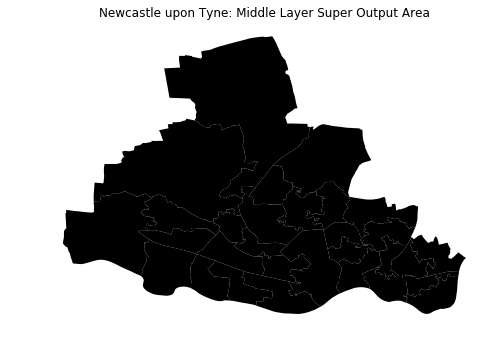

In [95]:
lsoa = gpd.read_file(LSOA_SHAPE_FOLDER+'Middle_Layer_Super_Output_Areas_December_2011_Full_Extent_Boundaries_in_England_and_Wales.shp')
lsoa = lsoa[lsoa['msoa11nm'].str.contains('Newcastle upon Tyne')]
lsoa = lsoa.to_crs(fiona.crs.from_epsg(4326))
lsoa.crs = {'init': 'epsg:4326', 'no_defs': True}

fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(7,5))
lsoa.plot(ax=axes,color='black')
plt.axis('off')
plt.title('Newcastle upon Tyne: Middle Layer Super Output Area')
plt.tight_layout()
plt.savefig(DATA_FOLDER+'plots/mlsoa_newcastle.svg', format='svg', dpi=600)

Filtering lines and points within LSOA of Newcastle Upon Tyne

In [9]:
lines = gpd.sjoin(lines, lsoa, how='inner' ,op='intersects')[lines.columns]
points = gpd.sjoin(points, lsoa, how='inner' ,op='intersects')[points.columns]

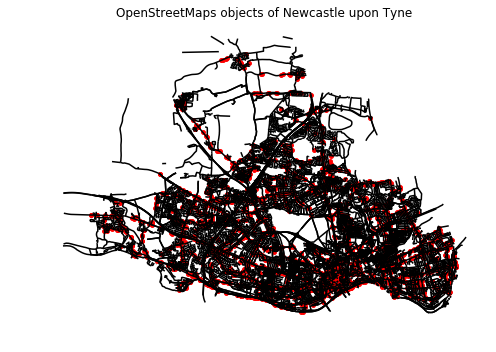

In [96]:
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(7,5))
lines.plot(ax=axes,color='black')
points.plot(ax=axes,color='red',markersize=15)
plt.axis('off')
plt.title('OpenStreetMaps objects of Newcastle upon Tyne')
plt.tight_layout()
plt.savefig(DATA_FOLDER+'plots/osm_newcastle_objects.svg', format='svg', dpi=600)

## Sensors data

In [38]:
metadata = pd.read_csv(DATA_FOLDER+'sensors.csv')

# spatial parsing - geometry column
metadata = gpd.GeoDataFrame(metadata[['name','type','active','lon','lat']],
                        geometry=[shapely.geometry.Point(xy) for xy in zip(metadata['lon'], metadata['lat'])], 
                        crs={'init': 'epsg:4326'}).to_crs(fiona.crs.from_epsg(4326))

metadata = gpd.sjoin(metadata, lsoa, how='inner' ,op='intersects')[['name','type','active','lon','lat','geometry']]
metadata = metadata.set_index('name')
print(metadata.shape)
metadata.head()

(147, 5)


,type,active,lon,lat,geometry
name,,,,,
CAJT_NCA186_WR1_WR2,Traffic,True,-1.632646,54.972302,POINT (-1.63264593718199 54.97230231629401)
CAJT_NCA186_WR2_WR1,Traffic,True,-1.632801,54.972415,POINT (-1.63280112824739 54.97241510275539)
BMS_Armstrong.Armstrong;KRBlrOATTrndOATTCast (OAT Castle Leazes Trend_MOM),Environmental,True,-1.629100,54.980600,POINT (-1.6291 54.9806)
CAJT_NCA186_WR2_WR1_BUS,Traffic,True,-1.632801,54.972415,POINT (-1.63280112824739 54.97241510275539)
CAJT_NCA186_WR1_WR2_BUS,Traffic,True,-1.632646,54.972302,POINT (-1.63264593718199 54.97230231629401)


In [39]:
# loading sensors data
sensors = pd.read_csv(DATA_FOLDER+'data.csv')
sensors['Timestamp'] = pd.to_datetime(sensors['Timestamp'])
sensors = sensors.set_index(['Variable','Sensor Name','Timestamp'])
# resampling to daily medians
level_values = sensors.index.get_level_values
sensors = (sensors.groupby([level_values(i) for i in [0,1]]
                   +[pd.Grouper(freq='D', level=-1)]).median())
m = metadata.index.values
s = sensors.reset_index()
s = s.loc[s['Sensor Name'].isin(m)]
sensors = s.set_index(['Variable','Sensor Name','Timestamp'])
metadata = metadata.loc[sensors.index.get_level_values(1).unique()]

In [47]:
# this is for generate a label (0,1,2,3) for the variable intensity median on each sensor
def encoding_sensor_variable_classe(sensors, var):
    df = sensors.loc['NO2'].groupby('Sensor Name').mean()

    def f(x):
        if x<df.quantile(0.25)['Value']:
            return 0
        elif x<df.quantile(0.5)['Value']:
            return 1
        elif x<df.quantile(0.75)['Value']:
            return 2
        else:
            return 3
    df['Value'] = df['Value'].apply(f)
    return df

## Spatial features extraction

In [43]:
def spatial_features(lines, points, metadata, distance):
    l = ['cycleway','primary','secondary','service','footway','residential']
    p = ['traffic_signals','bus_stop','crossing']

    lines = lines[lines['highway'].isin(l)]
    points = points[points['highway'].isin(p)]

    ldf = pd.DataFrame(columns=l)
    pdf = pd.DataFrame(columns=p)

    for m in range(metadata.shape[0]):
        i = metadata.iloc[m]

        # distance of 0.0011 = 100m radius
        lfeatures = lines[lines['geometry'].apply(lambda x: x.distance(i['geometry']))<distance]['highway'].value_counts().reindex(lines['highway'].unique(), fill_value=0)
        ldf.loc[i.name] = lfeatures[l]

        pfeatures = points[points['geometry'].apply(lambda x: x.distance(i['geometry']))<distance]['highway'].value_counts().reindex(points['highway'].unique(), fill_value=0)
        pdf.loc[i.name] = pfeatures[p]
    return pd.concat([ldf,pdf],axis=1)
if False:
    spatial_features(lines, points, metadata, 0.0011).to_csv(DATA_FOLDER+'street_features_newcastle.csv')

### Experiments on the spatial features distribution for NO2 prediction

Varying distance parameter on spatial_features()

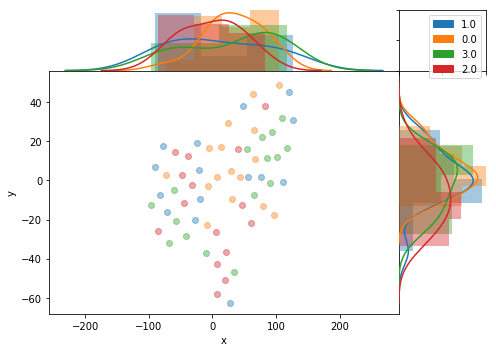

In [97]:
#1km

s1km = spatial_features(lines, points, metadata, 0.011)
s1km = s1km.join(encoding_sensor_variable_classe(sensors, 'NO2')).dropna()
tsne = TSNE(n_components=2, random_state=0).fit_transform(s1km[s1km.columns[:-1]])
tsne = pd.DataFrame(tsne, columns=['x','y'])
tsne['NO2'] = s1km['Value'].values

fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(7,5))
jointplot_w_hue(data=tsne, x='x', y='y', hue='NO2', fig=fig, path=DATA_FOLDER+'plots/streetfeatures_count_1km.svg')['fig']

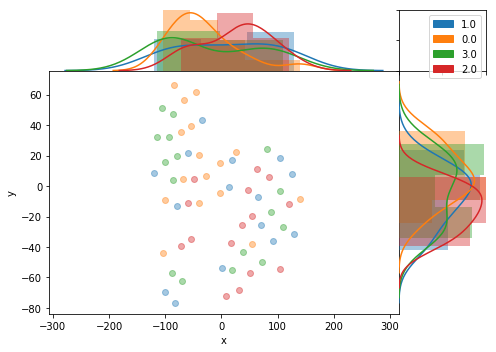

In [98]:
#500m

s500m = spatial_features(lines, points, metadata, 0.0055)
s500m = s500m.join(encoding_sensor_variable_classe(sensors, 'NO2')).dropna()
tsne = TSNE(n_components=2, random_state=0).fit_transform(s500m[s500m.columns[:-1]])
tsne = pd.DataFrame(tsne, columns=['x','y'])
tsne['NO2'] = s500m['Value'].values

fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(7,5))
jointplot_w_hue(data=tsne, x='x', y='y', hue='NO2', fig=fig, path=DATA_FOLDER+'plots/streetfeatures_count_500m.svg')['fig']

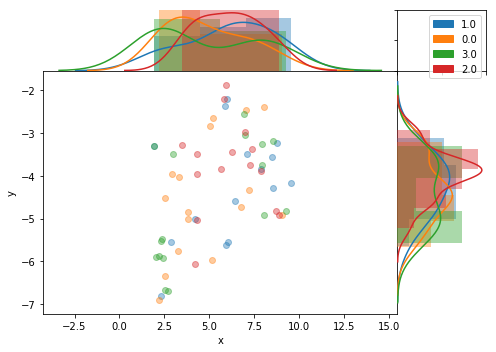

In [99]:
#100m

s100m = spatial_features(lines, points, metadata, 0.0011)
s100m = s100m.join(encoding_sensor_variable_classe(sensors, 'NO2')).dropna()
tsne = TSNE(n_components=2, random_state=0).fit_transform(s100m[s100m.columns[:-1]])
tsne = pd.DataFrame(tsne, columns=['x','y'])
tsne['NO2'] = s100m['Value'].values

fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(7,5))
jointplot_w_hue(data=tsne, x='x', y='y', hue='NO2', fig=fig, path=DATA_FOLDER+'plots/streetfeatures_count_100m.svg')['fig']

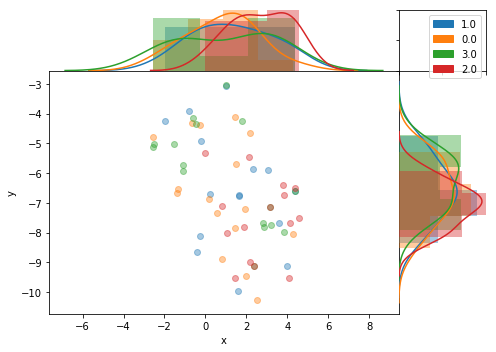

In [100]:
#50m

s50m = spatial_features(lines, points, metadata, 0.00055)
s50m = s50m.join(encoding_sensor_variable_classe(sensors, 'NO2')).dropna()
tsne = TSNE(n_components=2, random_state=0).fit_transform(s50m[s50m.columns[:-1]])
tsne = pd.DataFrame(tsne, columns=['x','y'])
tsne['NO2'] = s50m['Value'].values

fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(7,5))
jointplot_w_hue(data=tsne, x='x', y='y', hue='NO2', fig=fig, path=DATA_FOLDER+'plots/streetfeatures_count_50m.svg')['fig']

In [90]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

def jointplot_w_hue(data, x, y, hue=None, colormap = None, 
                    figsize = None, fig = None, path=None, scatter_kws=None):
    #defaults
    if colormap is None:
        colormap = sns.color_palette() #['blue','orange']
    if figsize is None:
        figsize = (5,5)
    if fig is None:
        fig  = plt.figure(figsize = figsize)
    if scatter_kws is None:
        scatter_kws = dict(alpha=0.4, lw=1)
        
    # derived variables
    if hue is None:
        return "use normal sns.jointplot"
    hue_groups = data[hue].unique()

    subdata = dict()
    colors = dict()
    
    active_colormap = colormap[0: len(hue_groups)]
    legend_mapping = []
    for hue_grp, color in zip(hue_groups, active_colormap):
        legend_entry = mpatches.Patch(color=color, label=hue_grp)
        legend_mapping.append(legend_entry)
        
        subdata[hue_grp] = data[data[hue]==hue_grp]
        colors[hue_grp] = color
        
    # canvas setup
    grid = gridspec.GridSpec(2, 2,
                           width_ratios=[4, 1],
                           height_ratios=[1, 4],
                           hspace = 0, wspace = 0
                           )
    ax_main    = plt.subplot(grid[1,0])
    ax_xhist   = plt.subplot(grid[0,0], sharex=ax_main)
    ax_yhist   = plt.subplot(grid[1,1])#, sharey=ax_main)
    
    ## plotting
   
    # histplot x-axis
    for hue_grp in hue_groups:
        sns.distplot(subdata[hue_grp][x], color = colors[hue_grp]
                     , ax = ax_xhist).axis('off')

    # histplot y-axis
    for hue_grp in hue_groups:
        sns.distplot(subdata[hue_grp][y], color = colors[hue_grp]
                     , ax = ax_yhist, vertical=True).axis('off') 

    # main scatterplot 
    # note: must be after the histplots else ax_yhist messes up
    for hue_grp in hue_groups:
        sns.regplot(data = subdata[hue_grp], fit_reg=False,
                    x = x, y = y, ax = ax_main, color = colors[hue_grp]
                    , scatter_kws=scatter_kws
                   )        
    
    # topright 
    ax_legend   = plt.subplot(grid[0,1])#, sharey=ax_main)
    plt.setp(ax_legend.get_xticklabels(), visible=False)
    plt.setp(ax_legend.get_yticklabels(), visible=False)

    ax_legend.legend(handles=legend_mapping)
    plt.tight_layout()
    if path is not None:
        plt.savefig(path, format='svg', dpi=600)
    plt.close()
    return dict(fig = fig, gridspec = grid)